<a href="https://colab.research.google.com/github/shgyg99/handwrittenmathsolutions/blob/main/mathTOlatex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🔴ENVIRONMENT SETUP**

In [1]:
!pip install -q torchmetrics
!pip install -q wandb
!pip install -q fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 805.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00


In [3]:
!pip uninstall torchvision torch -y
!pip install -q torch==2.5 torchvision==0.20

Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 691.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.5.0 which is incompatible.


# **🔴IMPORT LIBS**

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms as TT
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch.nn import functional as F

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import wandb
import tqdm
import torchmetrics as tm
from PIL import Image

# **🔴UTILS**

In [5]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# **🔴ARGUMENTS**

In [8]:
seed = 8
path = '/content/drive/MyDrive/papersFolder'
embed_size=256
hidden_size=512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.5
batch_size=32
lr = 1e-2
momentum=0.9
num_epoch = 10
wandb_enable = False
seq_len = 20

In [9]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# **🔴CUSTOM DATASET**

In [52]:
# tokens = [
#     '\\', '{', '}', '^', '+', '-', "'", '_', '!', '.', '/', '&', '%', '*',
#     '\\frac', '\\times', '\\lim', '\\sin', '\\cos', '\\tan', '\\cot', '\\csc', '\\sec',
#     '\\sqrt', '\\sum', '\\rightarrow', '\\Rightarrow', '\\leftarrow', '\\Leftarrow',
#     '\\right', '\\left', '\\alpha', '\\beta', '|', '\\Delta', '\\delta', '\\gamma', '\\lambda',
#     '\\min', '\\max', '(', ')', '<', '>', '=', '\\pm', '\\mp', '\\neq', '\\infty', '\\matrix',
#     '[', ']', '\\in', '\\notin', '\\cap', '\\cup', '\\begin', '\\end', '\\dots', '\\int', ':',
#     '\\ln', '\\pi', '\\theta', '\\to', '\\arctan', '\\arccot', '\\arcsin', '\\arccos',
#     '\\log', '\\sinh', '\\cosh', '\\coth', '\\tanh', '\\degree', '\\dev', '\\sim',
#     '\\forall', '\\emptyset', '\\buildrelF', '\\bar', '\\exists', '\\varepsilon', '\\partial',
#     '\\hat', '\\triangle', '\\mathbb', '\\simeq',
#     'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
#     'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
#     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
# ]

# tokenizer = Tokenizer(models.BPE())

# special_tokens = ["<s>", "</s>", "<unk>", "<pad>"] + tokens
# trainer = trainers.BpeTrainer(vocab_size=len(special_tokens), special_tokens=special_tokens)

# tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# files = ["/content/drive/MyDrive/papersFolder/latex_formulas.txt"]
# tokenizer.train(files, trainer)

# # ذخیره مدل
# tokenizer.save("/content/drive/MyDrive/papersFolder/latex_tokenizer.json")

# print("✅Done")

✅Done


In [53]:
def target_transform(label):
  tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
  encoded_label = tokenizer.encode(f'<s>{label}</s>')
  return torch.LongTensor(encoded_label.ids)

In [54]:
image_transform = TT.Compose([
    TT.Grayscale(num_output_channels=1),
    TT.Resize((256, 512)),
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
])

In [55]:
class LatexImages(Dataset):
  def __init__(self, path, image_transform=None, target_transform=None):
    self.path = path
    self.image_transform = image_transform
    self.target_transform = target_transform

    csv = pd.read_csv(os.path.join(self.path, 'merged_sorted.csv'))

    self.image_paths = []
    self.labels = []
    for i in os.listdir(os.path.join(self.path, 'cropped')):
        image_path = fr'.\cropped\{i}'
        try:
          label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
          self.image_paths.append(os.path.join(self.path, 'cropped', i))
          self.labels.append(label)
        except:
          pass


  def __getitem__(self, index):
    image_path = self.image_paths[index]

    if self.target_transform:
      label = self.target_transform(self.labels[index])
    else:
      label = self.labels[index]

    if self.image_transform:
      image = self.image_transform(Image.open(image_path))
    else:
      image = Image.open(image_path)

    return image, label

  def __len__(self):
    return len(self.image_paths)

In [56]:
dataset = LatexImages(path=path, image_transform=image_transform, target_transform=target_transform)

torch.Size([1, 256, 512]) torch.Size([23])


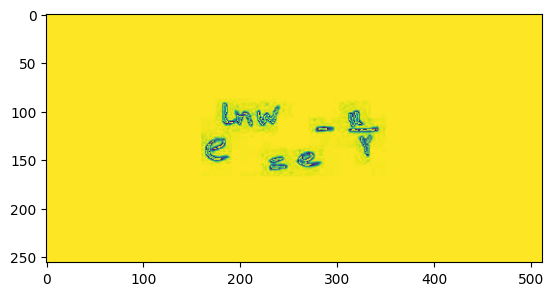

In [57]:
im, la = dataset.__getitem__(np.random.randint(0, dataset.__len__()))

plt.imshow(TT.ToPILImage()(im))
print(im.shape, la.shape)

# **🔴Data Loader**

In [64]:
train_set, test_set = random_split(dataset, [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*0.9)])

In [63]:
def collate_fn(data):
  tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
  tensors, targets = zip(*data)
  features = pad_sequence(targets, padding_value=tokenizer.get_vocab()['<pad>'], batch_first=True)
  tensors = torch.stack(tensors)
  return tensors, features

In [65]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)

In [68]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 256, 512]), torch.Size([32, 52]))

# **🔴Functions**

In [66]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric=None, epoch=None):
  model.train()
  loss_train = AverageMeter()
  if metric:
    metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      if metric:
        metric.update(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())


      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item() if metric else None)
  return model, loss_train.avg, metric.compute().item() if metric else None

In [67]:
def evaluate(model, test_loader, loss_fn, metric=None):
  model.eval()
  loss_eval = AverageMeter()
  if metric:
    metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      if metric:
        metric.update(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      return loss_eval.avg, metric.compute().item() if metric else None

# **🔴Model**